# Data Set Information:

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head(5)

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

# 1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
df.shape

(48204, 9)

In [5]:
df.describe()

temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000

**Удалим неинтересующие нас столбцы**

In [6]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [7]:
df = df.drop(columns=['rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description'], axis=1)
df.head(2)

holiday    temp            date_time  traffic_volume
0     NaN  288.28  2012-10-02 09:00:00            5545
1     NaN  289.36  2012-10-02 10:00:00            4516

In [8]:
df['holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [9]:
df['temp'].unique()

array([288.28, 289.36, 289.58, ..., 306.08, 304.41, 304.9 ])

**Конверитируем колонку date_time в datetime и устанавливаем её как индекс**

In [10]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [11]:
df = df.set_index(pd.DatetimeIndex(df['date_time']))

**Проверим дубликаты**

In [12]:
df.duplicated().sum()

7551

In [13]:
df = df.drop_duplicates()

In [14]:
df.duplicated().sum()

0

In [15]:
df.shape

(40653, 4)

**Взглянем на пропущенные значения**

In [16]:
df.isna().sum()

holiday           40600
temp                  0
date_time             0
traffic_volume        0
dtype: int64

**Временной промежуток в датасете**

In [17]:
len(df['date_time'].unique())

40575

А вот реальный промежуток...

Видим пропуски. Реальная временная метка, **length=52551**

Поработаем над пропусками

In [19]:
# Создадим  DataFrame без пропусков во времени
data = pd.DataFrame({'real_date_time': pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')})

In [20]:
# Приведём к формату datetime
data['date_time'] =  pd.to_datetime(data['real_date_time'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# Сделаем индексы
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [22]:
data.head(2)

real_date_time           date_time
date_time                                                  
2012-10-02 09:00:00 2012-10-02 09:00:00 2012-10-02 09:00:00
2012-10-02 10:00:00 2012-10-02 10:00:00 2012-10-02 10:00:00

In [23]:
data = data.drop(columns=['date_time'], axis=1)

In [24]:
data.head(2)

real_date_time
date_time                              
2012-10-02 09:00:00 2012-10-02 09:00:00
2012-10-02 10:00:00 2012-10-02 10:00:00

In [25]:
len(data)

52551

In [26]:
len(df)

40653

In [27]:
df.head(2)

holiday    temp           date_time  traffic_volume
date_time                                                              
2012-10-02 09:00:00     NaN  288.28 2012-10-02 09:00:00            5545
2012-10-02 10:00:00     NaN  289.36 2012-10-02 10:00:00            4516

In [28]:
df_new = data.merge(df, how='left', left_on='real_date_time', right_index=True)

In [29]:
df_new = df_new.set_index('date_time')

In [30]:
len(df_new)

52629

In [31]:
df_new.head(3)

real_date_time holiday    temp  traffic_volume
date_time                                                              
2012-10-02 09:00:00 2012-10-02 09:00:00     NaN  288.28          5545.0
2012-10-02 10:00:00 2012-10-02 10:00:00     NaN  289.36          4516.0
2012-10-02 11:00:00 2012-10-02 11:00:00     NaN  289.58          4767.0

In [32]:
df_new = df_new.drop(columns=['real_date_time'], axis=1)

In [33]:
df = df_new.interpolate(method='linear')
df.head(3)

holiday    temp  traffic_volume
date_time                                          
2012-10-02 09:00:00     NaN  288.28          5545.0
2012-10-02 10:00:00     NaN  289.36          4516.0
2012-10-02 11:00:00     NaN  289.58          4767.0

**Попробуем взять только данные с июня 2018 по 30 сентября 2018**

In [34]:
#end_date = df.index.max()
#start_date = end_date - pd.DateOffset(months=5)
#print(f"start date: {start_date} \nend date: {end_date}")
#train_data = df.loc[start_date:end_date]
#df = df['2018-06-01':'2018-09-30']
#train_data.head()
df = df[(df.index >= '2018-06-01' ) & (df.index <= '2018-09-30')]
df.head()

holiday    temp  traffic_volume
date_time                                          
2018-06-01 00:00:00     NaN  294.28           786.0
2018-06-01 01:00:00     NaN  293.22           497.0
2018-06-01 02:00:00     NaN  292.22           346.0
2018-06-01 03:00:00     NaN  291.43           395.0
2018-06-01 04:00:00     NaN  291.15           872.0

In [35]:
df.shape

(2900, 3)

**Отложим последние две недели из датасета для тестов**

In [36]:
split_date = '2018-09-16'
df_train = df.iloc[df.index < split_date].copy()
df_test = df.iloc[df.index > split_date].copy()

In [37]:
(df_train.shape, df_test.shape)

((2563, 3), (336, 3))

In [38]:
def plot_data(df):
  """ Отрисовка временного ряда """
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

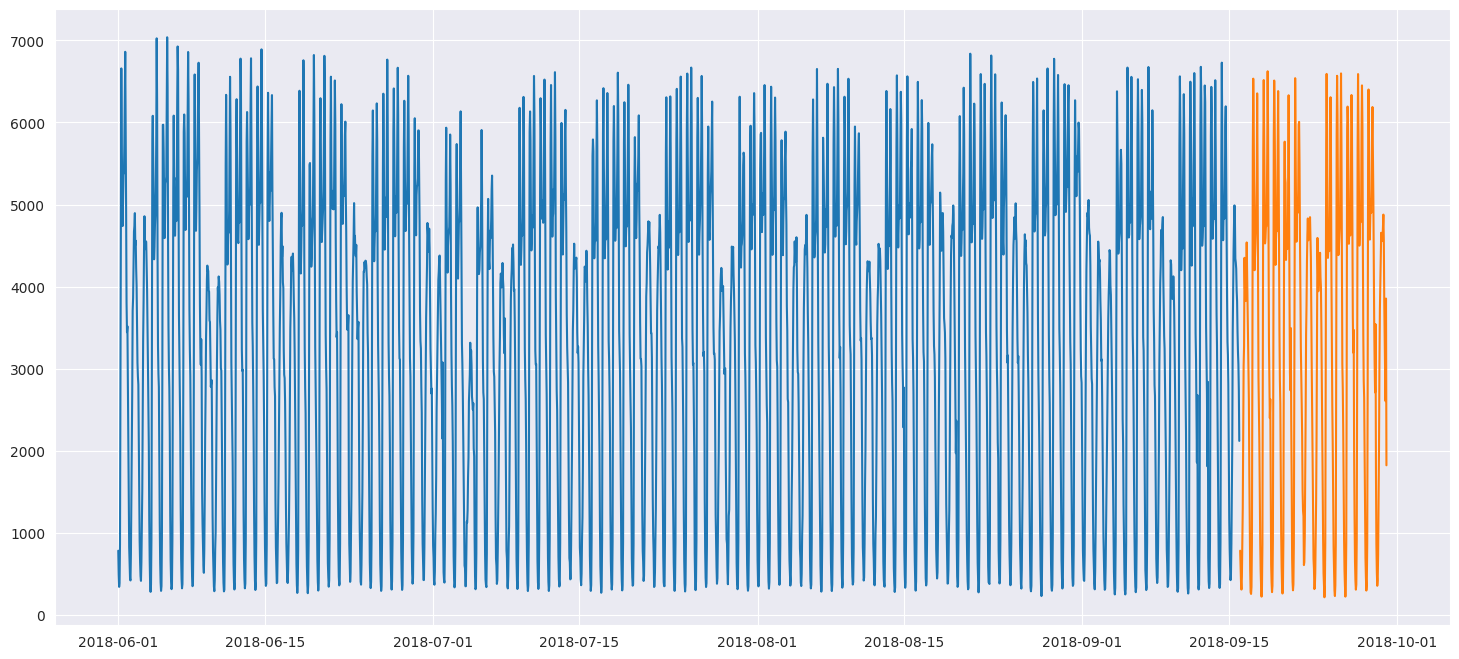

In [39]:
plot_data(df)

# Генерируем дополнительные признаки

In [40]:
def create_features(df, label=None):
    """
    Генерируем дополнительные признаки из datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year']]
    
    if label:
        y = df[label]
        return X, y
    return X

**Метрики**

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 

  """ MAPE """
  
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
def error_metrics(y_true, y_pred):

  """ Подсчёт метрик и вывод на экран """
  
  print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
  print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
  print('Mean Absolute Percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

# Baseline

In [43]:
new_features_train = create_features(df_train)

In [44]:
df_groupby_train = df_train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [45]:
new_features_test = create_features(df_test)

In [46]:
df_groupby_test = df_test.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

Интересно, какие метрики покажет Baseline

In [47]:
error_metrics(df_groupby_train, df_groupby_test)

Mean Absolute Error: 174.04
Root Mean Squared Error: 234.08
Mean Absolute Percentage Error: 7.38 %


**Деление на train и test**

In [48]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2563, 8), (336, 8), (2563,), (336,))

# LinearRegression

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [51]:
%%time
y_pred = lr.predict(X_test)

CPU times: user 7.94 ms, sys: 1.84 ms, total: 9.78 ms
Wall time: 17.4 ms


In [52]:
def plot_predictions(y_pred):
  """ Отрисока предсказаний """
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

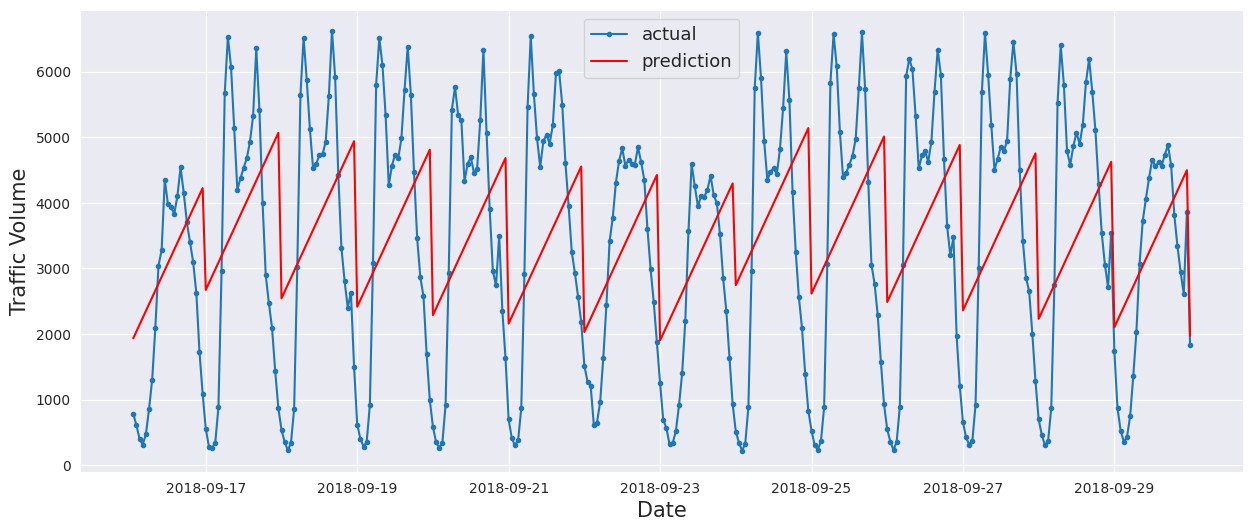

In [53]:
plot_predictions(y_pred)

In [54]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1587.52
Root Mean Squared Error: 1820.33
Mean Absolute Percentage Error: 141.67 %


In [55]:
def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

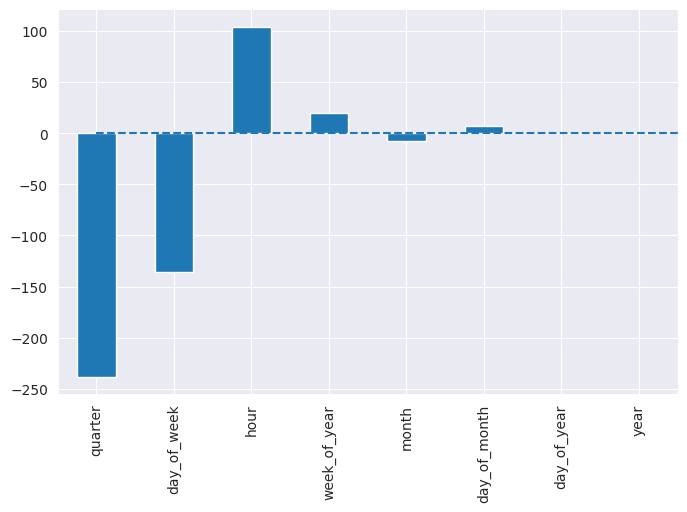

In [56]:
plotCoefficients(lr, X_train)

# RandomForestClassifier

In [57]:
%%time
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

CPU times: user 679 ms, sys: 39.8 ms, total: 719 ms
Wall time: 741 ms


RandomForestClassifier(max_depth=3, random_state=42)

In [58]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 307 ms, sys: 20 ms, total: 327 ms
Wall time: 388 ms


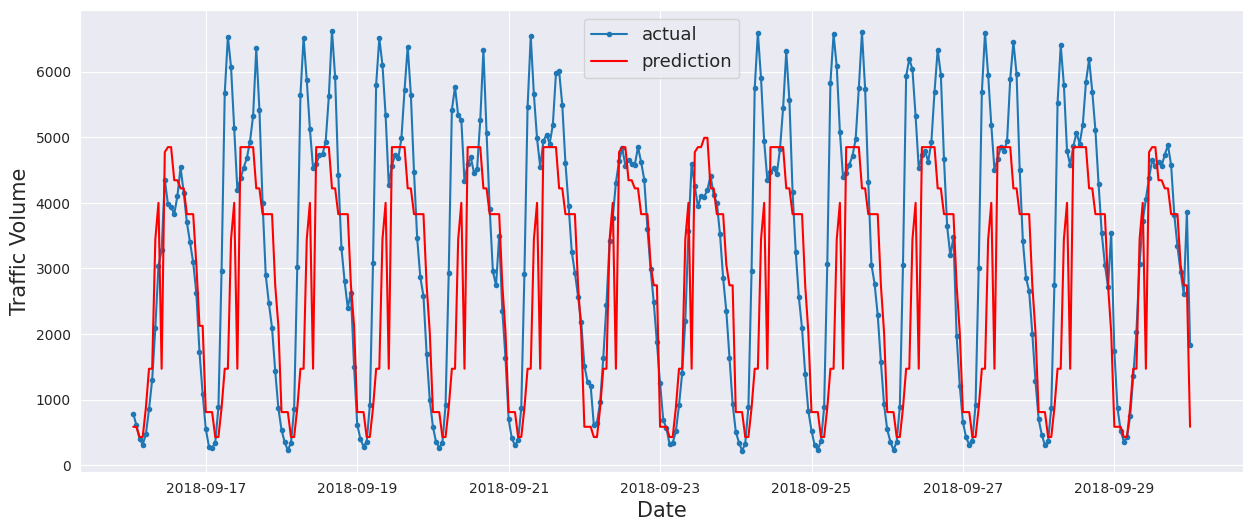

In [59]:
plot_predictions(y_pred)

In [60]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1028.32
Root Mean Squared Error: 1561.23
Mean Absolute Percentage Error: 40.49 %


# GradientBoostingRegressor

In [61]:
%time
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)

CPU times: user 8 μs, sys: 1e+03 ns, total: 9 μs
Wall time: 17.4 μs


GradientBoostingRegressor()

In [62]:
%%time
y_pred = gb.predict(X_test)

CPU times: user 11.9 ms, sys: 988 μs, total: 12.9 ms
Wall time: 15.8 ms


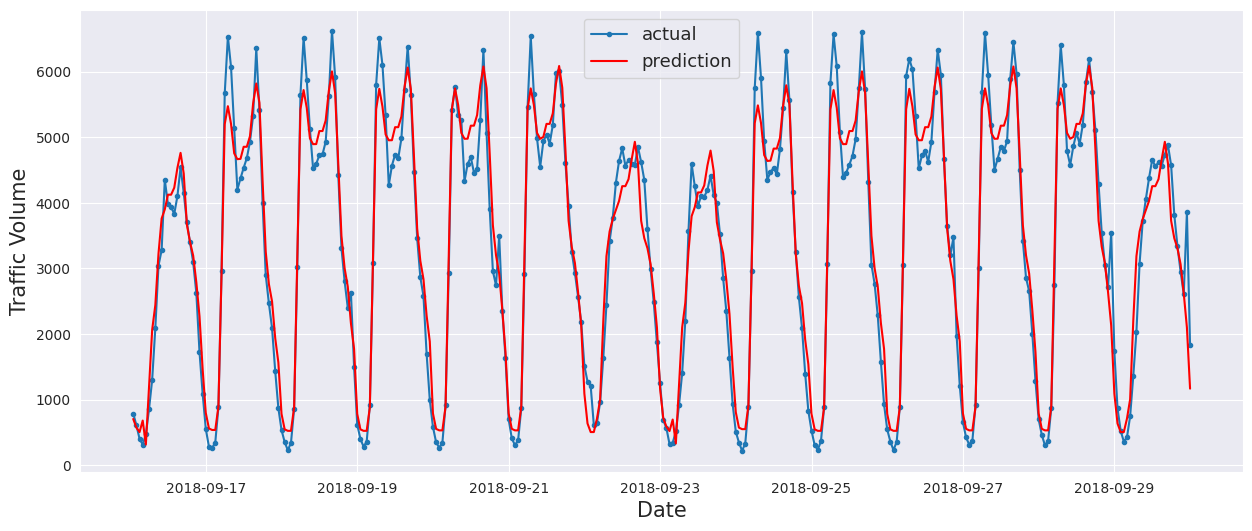

In [63]:
plot_predictions(y_pred)

In [64]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 314.30
Root Mean Squared Error: 400.21
Mean Absolute Percentage Error: 18.48 %


# XGBRegressor

In [65]:
%%time
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train)

CPU times: user 4.02 s, sys: 51.9 ms, total: 4.08 s
Wall time: 2.12 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
%%time
y_pred = reg.predict(X_test)

CPU times: user 47.5 ms, sys: 1.98 ms, total: 49.5 ms
Wall time: 28.8 ms


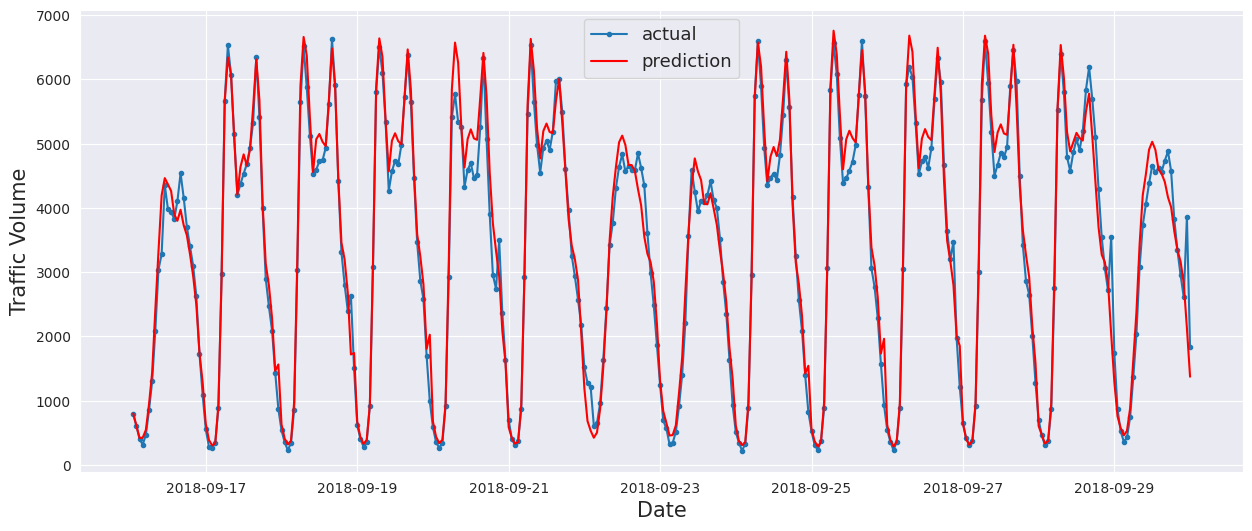

In [67]:
plot_predictions(y_pred)

In [68]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 235.22
Root Mean Squared Error: 330.60
Mean Absolute Percentage Error: 10.15 %


# Prophet

In [69]:
# !pip install prophet

In [81]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

def plot_plotly(m, fcst, uncertainty=True, plot_cap=True, trend=True, changepoints=True,
                changepoints_threshold=0.01, xlabel='ds', ylabel='y', figsize=(700, 450)):
    data = []
    # Add actual
    data.append(go.Scatter(
        name='Actual',
        x=m.history['ds'],
        y=m.history['y'],
        marker=dict(color='rgb(0, 0, 255)', size=4),
        mode='markers'
    ))
    # Add lower bound
    if uncertainty and 'yhat_lower' in fcst:
        data.append(go.Scatter(
            name='Lower',
            x=fcst['ds'],
            y=fcst['yhat_lower'],
            mode='lines',
            line=dict(width=0),
            fillcolor='rgba(0, 0, 255, 0.2)',
            fill='tonexty'
        ))
    # Add upper bound
    if uncertainty and 'yhat_upper' in fcst:
        data.append(go.Scatter(
            name='Upper',
            x=fcst['ds'],
            y=fcst['yhat_upper'],
            mode='lines',
            line=dict(width=0),
            fillcolor='rgba(0, 0, 255, 0.2)',
            fill='tonexty'
        ))
    # Add forecast
    data.append(go.Scatter(
        name='Forecast',
        x=fcst['ds'],
        y=fcst['yhat'],
        mode='lines',
        line=dict(color='rgb(255, 0, 0)'),
    ))
    fig = go.Figure(data=data)
    fig.update_layout(
        showlegend=True,
        legend=dict(orientation='h'),
        xaxis=dict(title=xlabel),
        yaxis=dict(title=ylabel),
        title='Forecast'
    )
    fig.show()

df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df.index)
df_fbp["y"] = df['traffic_volume'].values

In [82]:
df_fbp.head()

ds      y
0 2018-06-01 00:00:00  786.0
1 2018-06-01 01:00:00  497.0
2 2018-06-01 02:00:00  346.0
3 2018-06-01 03:00:00  395.0
4 2018-06-01 04:00:00  872.0

In [83]:
fb_y_train = df_fbp.iloc[:-359].copy()
fb_y_test = df_fbp.iloc[-359:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [84]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
forecast.tail(2)

ds        trend  yhat_lower   yhat_upper  trend_lower  \
357 2018-09-29 23:00:00  3348.358624  -44.216072  1908.087976  3333.851085   
358 2018-09-30 00:00:00  3348.315367 -694.892015  1283.844703  3333.740483   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
357  3361.767736    -2405.850231          -2405.850231          -2405.850231   
358  3361.777615    -3014.685185          -3014.685185          -3014.685185   

           daily  daily_lower  daily_upper      weekly  weekly_lower  \
357 -1574.481857 -1574.481857 -1574.481857 -831.368374   -831.368374   
358 -2177.287911 -2177.287911 -2177.287911 -837.397274   -837.397274   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
357   -831.368374                   0.0                         0.0   
358   -837.397274                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
357                         0.0  942.508392  
358                         0.0  333.630182

In [86]:
forecast_pred = forecast['yhat'].copy().astype(np.float32)

In [87]:
forecast_test = fb_y_test['y'].copy().astype(np.float32)

In [88]:
error_metrics(forecast_test, forecast_pred)

Mean Absolute Error: 618.37
Root Mean Squared Error: 815.86
Mean Absolute Percentage Error: nan %


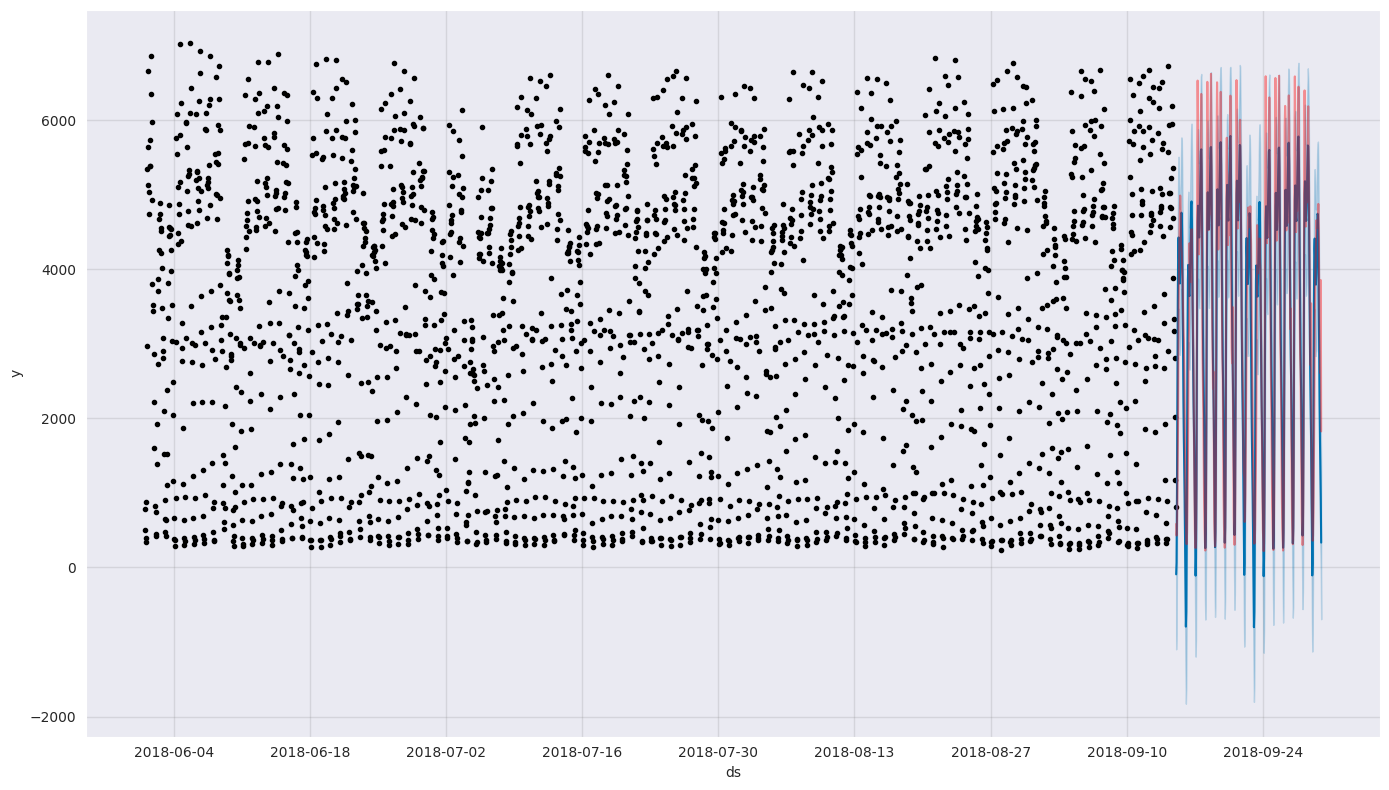

In [89]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [90]:
plot_plotly(fbmodel, forecast)

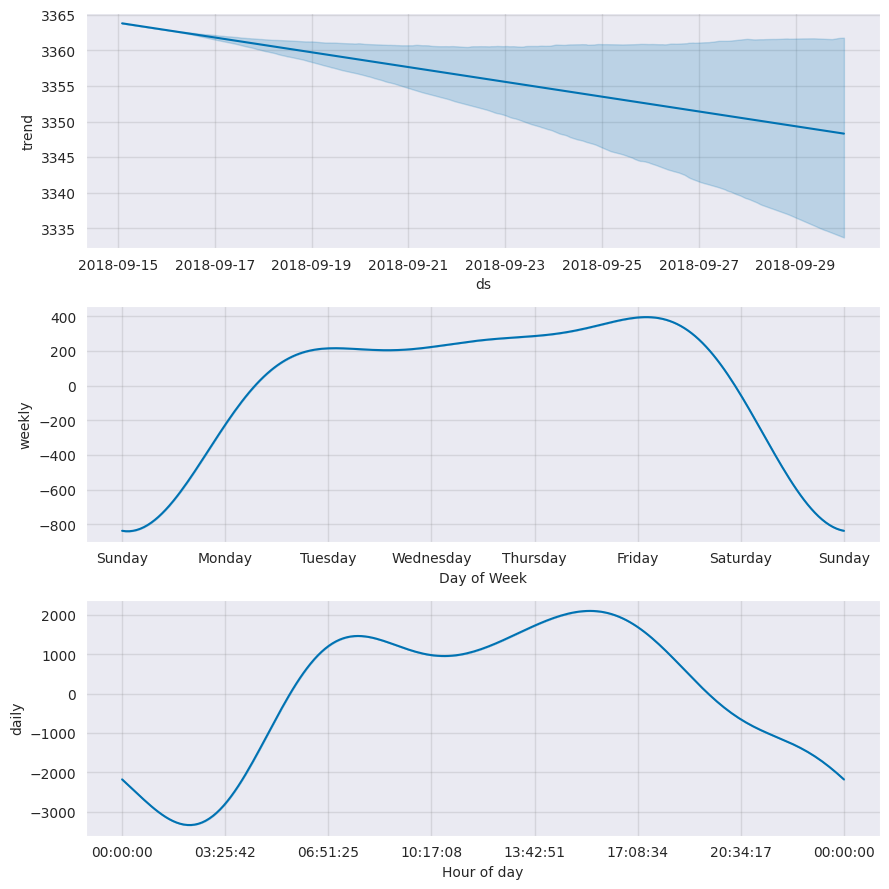

In [91]:
_ = fbmodel.plot_components(forecast)

# ARIMA

In [92]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/f0/89/b1ae45689abecca777f95462781a76e67ff46b55495a481ec5a73a739994/Cython-3.0.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 5.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [93]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [94]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df.traffic_volume)

(0.01, False)

In [96]:
df_arima = pd.DataFrame()
df_arima["ds"] = pd.to_datetime(df.index)
df_arima["y"] = df['traffic_volume'].values

arima_y_train = df_arima.iloc[:-359].copy()
arima_y_test = df_arima.iloc[-359:].copy()
arima_y_val = arima_y_test[["ds"]].copy()

In [97]:
arima_y_train = arima_y_train.drop(['ds'], axis=1)
arima_y_train

y
0      786.0
1      497.0
2      346.0
3      395.0
4      872.0
...      ...
2536  3169.0
2537  2810.0
2538  2024.0
2539  1179.0
2540   808.0

[2541 rows x 1 columns]

In [98]:
%%time
arima_model = auto_arima(y_train, m=12,
                        suppress_warnings=True, 
                        stepwise=True,
                        seasonal=True,
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=27.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=46061.475, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=40831.437, Time=5.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=42720.503, Time=6.35 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=49623.417, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=41405.752, Time=0.27 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=57.56 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=31.98 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=41181.361, Time=6.12 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=38959.762, Time=72.77 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=38951.457, Time=50.45 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=39414.100, Time=39.25 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=42540.611, Time=38.42 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=38020.428, Time=47.54 sec
 ARIMA(2,0,0)(1

In [99]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2563
Model:             SARIMAX(4, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood              -18974.570
Date:                                 Mon, 28 Oct 2024   AIC                          37969.139
Time:                                         14:22:31   BIC                          38027.628
Sample:                                              0   HQIC                         37990.347
                                                - 2563                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    414.5462     62.599      6.622      0.000     291.855     537.237
ar.L1          1.4284      0.013    112.782      0.000       1.404       1.453
ar.L2         -0.7051      0.027    -26.319      0.000      -0.758      -0.653
ar.L3          0.0474      0.036      1.313      0.189      -0.023       0.118
ar.L4          0.0283      0.024      1.199      0.231      -0.018       0.075
ar.S.L12      -0.2554      0.041     -6.297      0.000      -0.335      -0.176
ar.S.L24       0.6476      0.039     16.816      0.000       0.572       0.723
ma.S.L12       0.1169      0.049      2.390      0.017       0.021       0.213
ma.S.L24      -0.2151      0.039     -5.573      0.000      -0.291      -0.139
sigma2      1.566e+05   2854.955     54.859      0.000    1.51e+05    1.62e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):              1409.26
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.24
Prob(H) (two-sided):                  0.86   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
prediction = pd.DataFrame(arima_model.predict(n_periods=336))
prediction.columns = ['predicted_traffic_volume']
prediction.head(10)

/home/eugen/.cache/JetBrains/PyCharmCE2024.2/demo/PyCharmLearningProject/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



predicted_traffic_volume
2563               1486.510421
2564               1304.877647
2565               1248.940740
2566               1143.327365
2567               1238.233806
2568               1850.508800
2569               2643.641621
2570               3238.244126
2571               3832.406680
2572               4005.690993

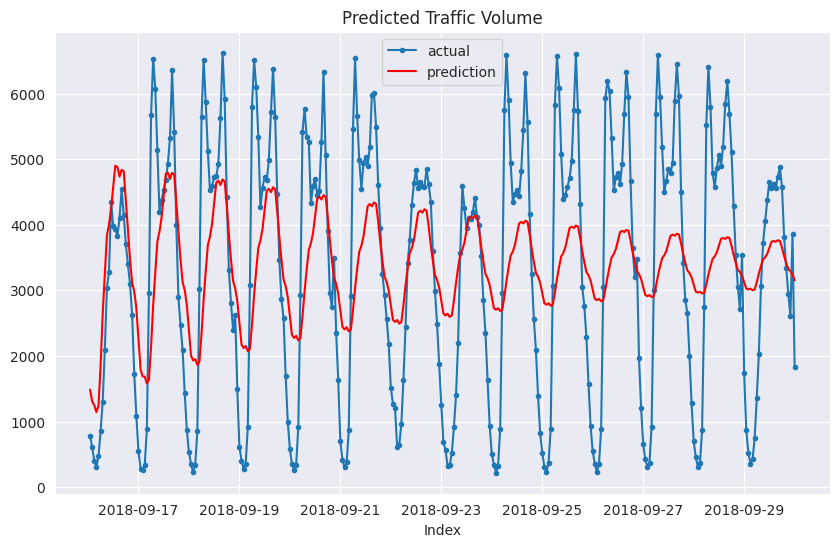

In [126]:
#plot_predictions(prediction)
plt.figure(figsize=(10, 6))
min_length = min(len(df_test.index), len(prediction['predicted_traffic_volume']))
plt.plot(df_test.index[:min_length], pd.DataFrame(df_test.traffic_volume).head(min_length), marker='.', label="actual")
plt.plot(df_test.index[:min_length], prediction['predicted_traffic_volume'][:min_length], 'r', label="prediction")
plt.title('Predicted Traffic Volume')
plt.xlabel('Index')
plt.legend()
plt.show()


In [128]:
r2_score(y_test, prediction)

0.35924697518517934

In [129]:
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, prediction)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 1298.30
Root Mean Squared Error: 1567.96


Итог

Model                       MAE         MSE
Baseline                    174.04      234.08
LinearRegression            1587.52     1820.33
RandomForestClassifier      1028.32     1561.23
GradientBoostingRegressor   314.30      400.21
XGBRegressor                235.22      330.60
Prophet                     618.37      815.86
ARIMA                       1298.30     1567.96

Модель Baseline показала наилучший результат